In [61]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyproj import Transformer
import xskillscore as xskill

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from stats import clean_xs_ys

xr.set_options(keep_attrs = True)

data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')
fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/model')

ds = xr.open_dataset(ncs_dir.joinpath('final_insitu.nc'))# .isel(x = slice(0, -1, 100), y = slice(0, -1, 100))

In [62]:
ds = ds.rolling(x = 10, y = 10).mean()

MemoryError: Unable to allocate 30.4 GiB for an array with shape (9, 17026, 26640) and data type float64

In [ ]:
sub = ds[['dem', 'int_phase','int_atm','unw_atm', 'model_d_swe','model_swe','cor', 'tree_perc', 'inc']]
sub = sub.where((sub['model_swe'].min(dim = 'time') > 0) & (~sub['cor'].mean(dim = 'time1').isnull()))

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


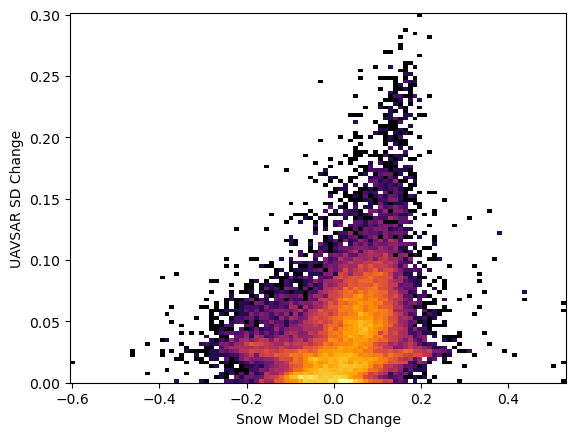

In [56]:
unw_sd = depth_from_phase(sub['unw_atm'].where(sub['model_d_swe'] > 0), sub['inc'], density = 250)
xs, ys = clean_xs_ys(unw_sd.data.ravel(), sub['model_d_swe'].data.ravel()*997/250)

plt.hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno) # range = [[-0.2, 0.5],[-0.2, 0.5]],
plt.xlabel('Snow Model SD Change')
plt.ylabel('UAVSAR SD Change')
plt.show()

In [ ]:
model_phase = phase_from_depth(sub['model_d_swe']*997/250, sub['inc'], density = 250)

sub['int_atm'] = sub['int_atm'] - (sub['int_atm'].mean(dim = ['x', 'y']) - model_phase.mean(dim = ['x', 'y']))
sub['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x', 'y']) - model_phase.mean(dim = ['x', 'y']))

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


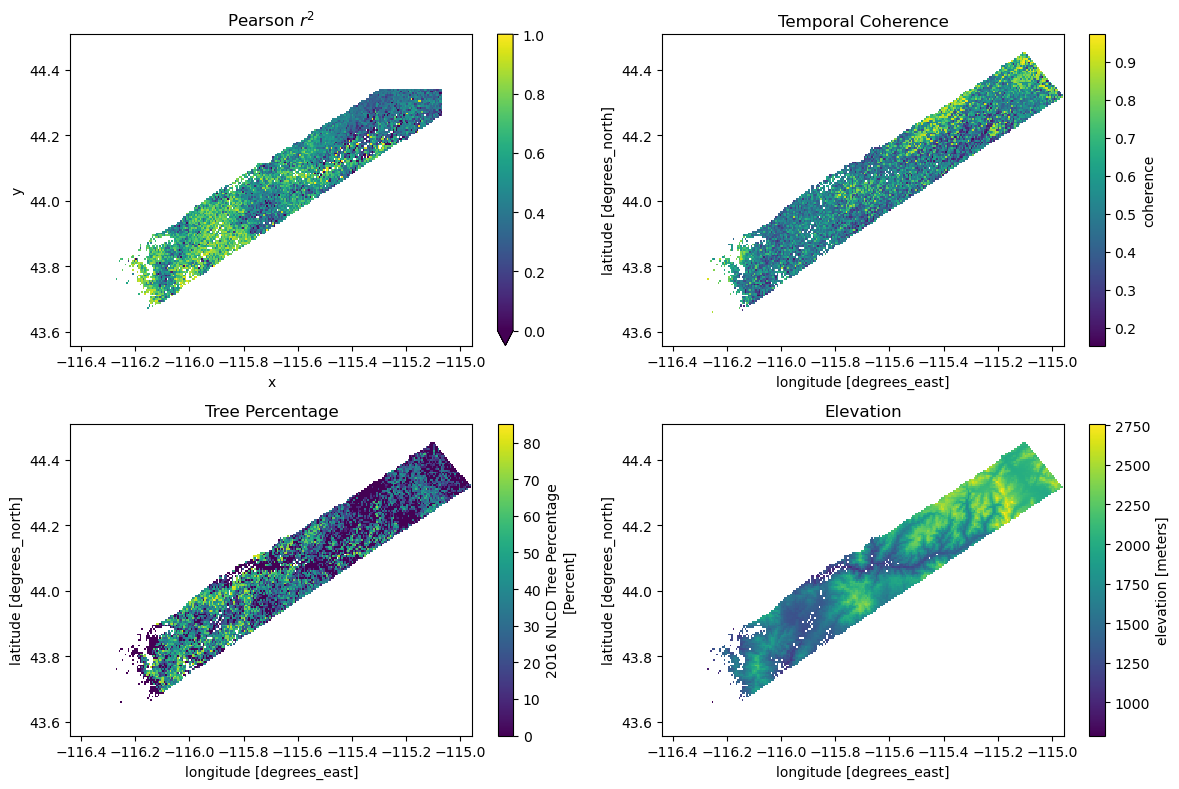

In [ ]:
model_phase = phase_from_depth(sub['model_d_swe']*997/250, sub['inc'], density = 250)
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
xskill.pearson_r(sub['int_atm'], model_phase, dim = 'time1', skipna = True).plot(vmax = 1, vmin = 0, ax= axes[0,0])
axes[0,0].set_title('Pearson $r^{2}$')
sub['cor'].mean(dim = 'time1').plot(ax = axes[0,1])
axes[0,1].set_title('Temporal Coherence')
sub['tree_perc'].plot(ax = axes[1, 0])
axes[1, 0].set_title('Tree Percentage')
sub['dem'].plot(ax = axes[1,1])
axes[1,1].set_title('Elevation')
plt.tight_layout()
plt.savefig(fig_dir.joinpath('r2_maps.png'))

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


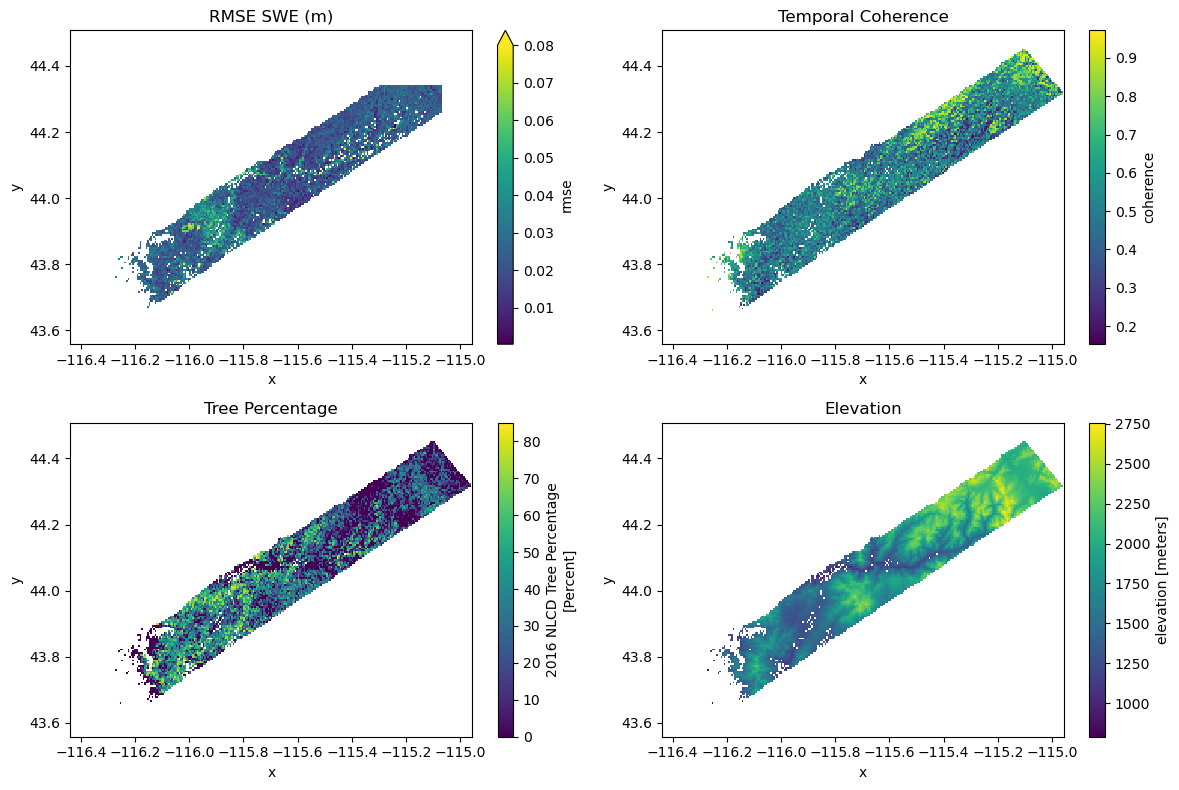

In [ ]:
int_sd = depth_from_phase(sub['unw_atm'], sub['inc'], density = 250)*250/997
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sub['rmse'] = xskill.rmse(sub['model_d_swe'], int_sd, dim = 'time1', skipna = True)
sub['rmse'].plot(ax= axes[0,0], vmax = 0.08)
axes[0,0].set_title('RMSE SWE (m)')
sub['cor'].mean(dim = 'time1').plot(ax = axes[0,1])
axes[0,1].set_title('Temporal Coherence')
sub['tree_perc'].plot(ax = axes[1, 0])
axes[1, 0].set_title('Tree Percentage')
sub['dem'].plot(ax = axes[1,1])
axes[1,1].set_title('Elevation')
plt.tight_layout()
plt.savefig(fig_dir.joinpath('rmse_maps.png'))

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


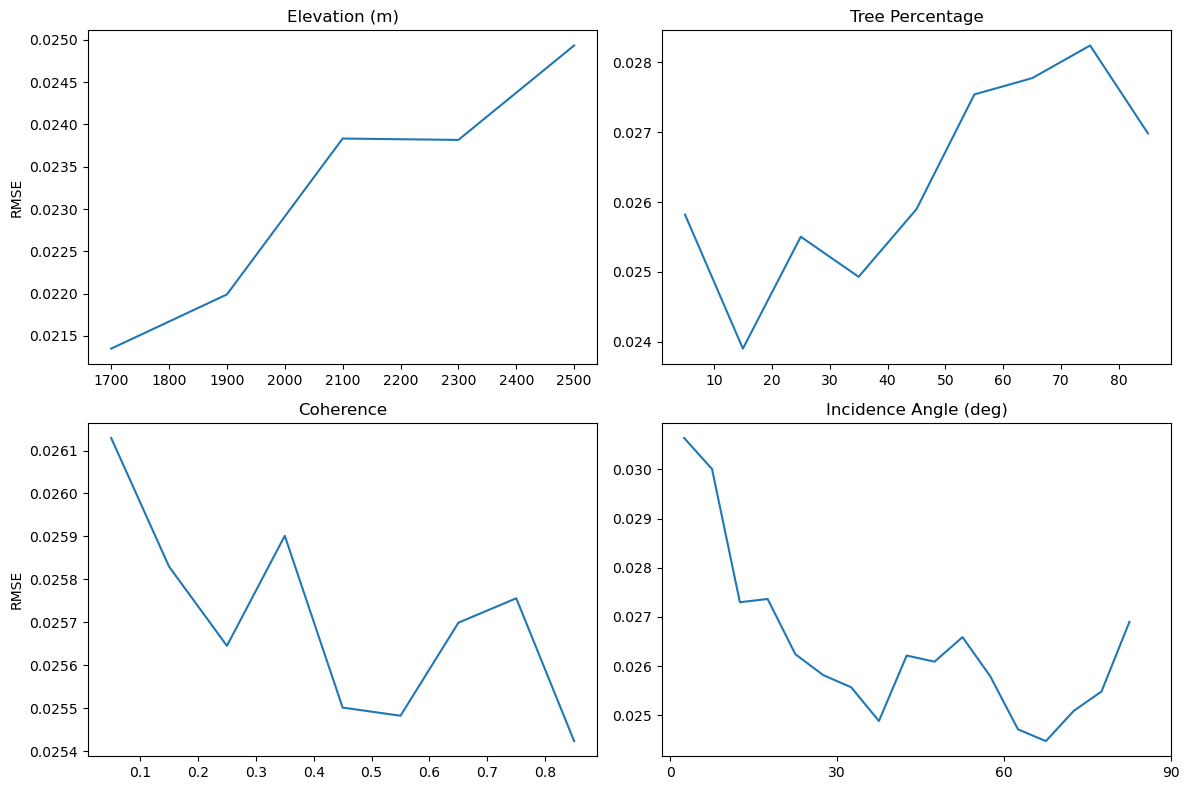

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (12, 8))
dem_group = sub.groupby_bins('dem', np.arange(1600, 2700, 200)).mean()
dem_group['rmse'].plot(ax = axes[0,0])
axes[0,0].set_title('Elevation (m)')

tree_group = sub.groupby_bins('tree_perc', np.arange(0, 100, 10)).mean()
tree_group['rmse'].plot(ax = axes[0, 1])
axes[0, 1].set_title('Tree Percentage')

cor_group = sub.groupby_bins('cor', np.arange(0, 1, 0.1)).mean()
cor_group['rmse'].plot(ax = axes[1,0 ])
axes[1, 0].set_title('Coherence')

inc_group = sub.groupby_bins('inc', np.arange(0, np.deg2rad(90), np.deg2rad(5))).mean()
inc_group['rmse'].plot(ax = axes[1,1])
axes[1,1].set_title('Incidence Angle (deg)')
# convert to degrees
tick_locs = np.deg2rad([0, 30, 60, 90])
tick_lbls = [0, 30, 60, 90]
plt.xticks(tick_locs, tick_lbls)

for ax in axes[:,0]:
    ax.set_ylabel('RMSE')

for ax in axes[:,1]:
    ax.set_ylabel('')

for ax in axes.ravel():
    ax.set_xlabel('')

plt.tight_layout()

plt.savefig(fig_dir.joinpath('rmse_binned.png'))

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


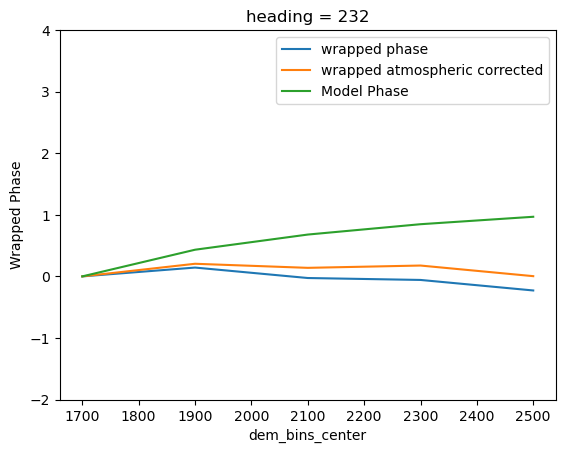

In [42]:
t = 1
fig, ax = plt.subplots()
elev_phase['int_phase'].plot(ax = ax, label = 'wrapped phase')
elev_phase['int_atm'].plot(ax = ax, label = 'wrapped atmospheric corrected')
phase_from_depth(elev_phase['model_d_swe']*997/250, np.deg2rad(40), density = 250).plot(ax = ax, label = 'Model Phase')
ax.set_ylabel('Wrapped Phase')
ax.set_ylim(-2, 4)
ax.legend()